In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Computech2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Computech2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Computech2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Load IMDb dataset
df = pd.read_csv("imdb_reviews.csv")  # Update filename if needed

# Text Cleaning Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Tokenization and Stopwords Removal
def preprocess_text(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Only Lemmatization
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmatized)

In [4]:
# Apply preprocessing to dataset
df['processed_text'] = df['review'].apply(lambda x: lemmatize_tokens(preprocess_text(x)))

In [5]:
# Convert labels to numerical values
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['sentiment'], test_size=0.2, random_state=42)

# Tokenization and Padding
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding="post", truncating="post")

y_train = np.array(y_train)
y_test = np.array(y_test)

In [6]:
# Define the Improved LSTM Model
def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
        LSTM(64, return_sequences=True),
        Dropout(0.5),
        LSTM(32, return_sequences=False),
        Dropout(0.5),
        Dense(16, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [7]:
# Train and Evaluate LSTM Model
print("Training LSTM Model...")
lstm_model = build_lstm_model()
history = lstm_model.fit(X_train_padded, y_train, epochs=15, batch_size=64, validation_data=(X_test_padded, y_test),
                         callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Training LSTM Model...
Epoch 1/15


C:\Users\Computech2\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 147ms/step - accuracy: 0.5003 - loss: 0.6937 - val_accuracy: 0.5083 - val_loss: 0.6853
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - accuracy: 0.5363 - loss: 0.6784 - val_accuracy: 0.6230 - val_loss: 0.6436
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.6996 - loss: 0.6019 - val_accuracy: 0.7445 - val_loss: 0.5546
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.7218 - loss: 0.5697 - val_accuracy: 0.5191 - val_loss: 0.6875
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.7236 - loss: 0.5648 - val_accuracy: 0.8094 - val_loss: 0.4629
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.8388 - loss: 0.4143 - val_accuracy: 0.8365 - val_loss: 0.4140
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 121ms/step - accuracy: 0.8642 - loss: 0.3549 - val_accuracy: 0.8478 - val_loss: 0.3736
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 150ms/step - accuracy: 0.8843 - loss: 0.3047 - val

In [8]:
# Evaluate the model
loss_lstm, accuracy_lstm = lstm_model.evaluate(X_test_padded, y_test)
print(f"LSTM Test Accuracy: {accuracy_lstm:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8605 - loss: 0.3307
LSTM Test Accuracy: 0.8610


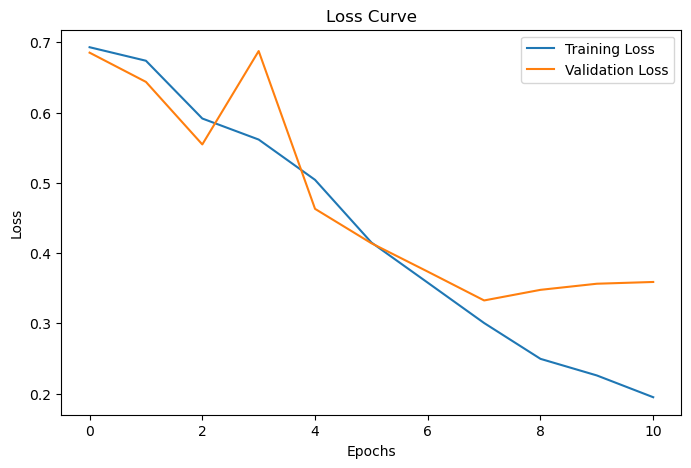

In [9]:

# Plot Loss Curve
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


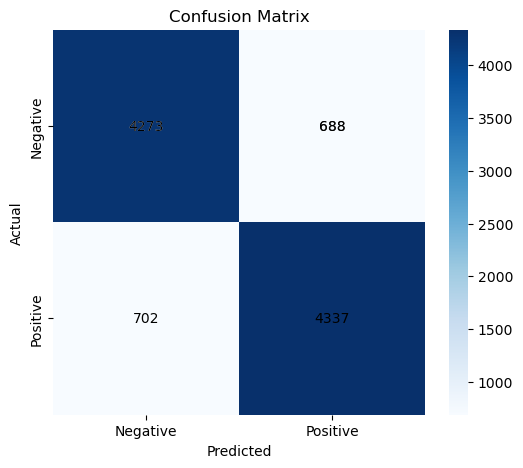

In [10]:
# Confusion Matrix
y_pred = (lstm_model.predict(X_test_padded) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Ensure all values are visible
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, str(conf_matrix[i, j]), 
                 ha='center', va='center', color='black')

plt.show()

In [11]:
def classify_review():
    user_input = input("Enter a review: ")
    
    # Full Preprocessing (Cleaning, Tokenization, Stopword Removal, Lemmatization)
    cleaned_input = clean_text(user_input)  # Remove HTML tags, special characters
    tokens = word_tokenize(cleaned_input)  # Tokenization
    stop_words = set(stopwords.words('english'))  
    filtered_tokens = [token for token in tokens if token not in stop_words]  # Remove Stopwords
    lemmatized_input = lemmatize_tokens(filtered_tokens)  # Lemmatization
    
    # Convert to sequence and pad for model input
    input_sequence = tokenizer.texts_to_sequences([lemmatized_input])
    input_padded = pad_sequences(input_sequence, maxlen=max_len, padding="post", truncating="post")
    
    # Predict Sentiment
    prediction = lstm_model.predict(input_padded)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    
    print(f"Predicted Sentiment: {sentiment} ({prediction:.4f})")
# Run classification for user input
classify_review()

Enter a review:  What makes a film truly memorable is how it resonates with the audience. Whether it leaves you inspired, entertained, or deep in thought, a good movie stays with you. It sparks conversations, makes you reflect on life, and sometimes even changes the way you see the world.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Sentiment: Positive (0.9838)
